# Ozone modelling
A practical example of modelling ozone levels, with manual variable selection via p-values and residual checking. The data contains

- **vh** - the height at which the atmospheric pressure is 500mb, in metres
- **wind** - the wind speed
- **humidity** - Percentage humidity 
- **temp** - air temperature in Fahrenheit
- **ibh** - the inversion layer base height in feet
- **ibt** - the inversion base temperature in Fahrenheit
- **dpg** - Dagget air pressure gradient in mmhg
- **vis** - visibility in miles
- **doy** - day of year 

In [1]:
import matplotlib.pyplot as plt

import pymgcv.plot as gplt
from pymgcv.families import Gamma, Gaussian
from pymgcv.gam import GAM
from pymgcv.terms import S
from pymgcv.utils import load_rdata_dataframe_from_url

data = load_rdata_dataframe_from_url(
    "https://github.com/mfasiolo/testGam/raw/master/data/ozone.rda",
)

data.columns = [c.lower().replace(".", "_") for c in data.columns]
data.head()

# 14.9, 18.4, 22.6

,o3,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
1,3,5710,4,28,40,2693,-25,87,250,33
2,5,5700,3,37,45,590,-24,128,100,34
3,5,5760,3,51,54,1450,25,139,60,35
4,6,5720,4,69,35,1568,15,121,60,36
5,4,5790,6,19,45,2631,-33,123,100,37


Let's define a basic model for ozone, `o3`, with Gaussian residuals and log link, using all possible covariates

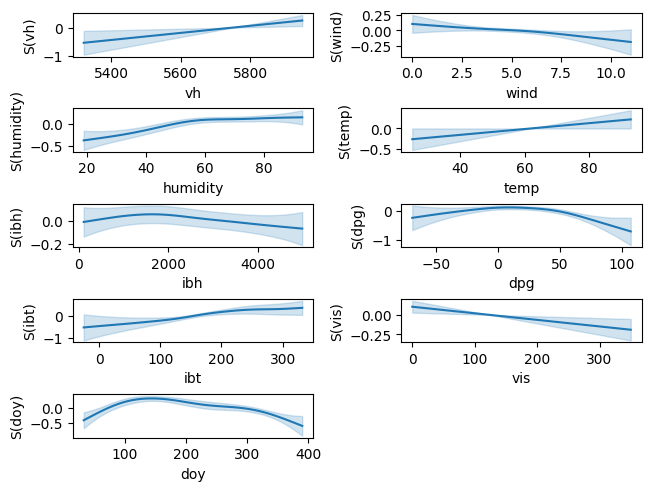

In [2]:
covariates = [colname for colname in data.columns if colname != "o3"]

gam_log_link = GAM(
    {"o3": [S(var) for var in covariates]},
    family=Gaussian(link="log"),
    )
gam_log_link.fit(data)
gplt.plot(gam_log_link, ncols=2);

In [3]:
from rpy2.robjects.packages import importr

for _i in range(10):
    stats = importr("base")

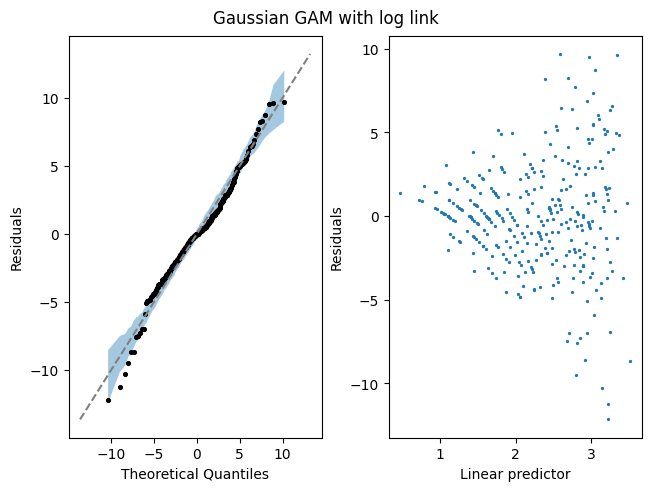

In [4]:
# Diagnostic plots
fig, axes = plt.subplots(ncols=2, layout="constrained")
gplt.qq(gam_log_link, ax=axes[0])
gplt.residuals_vs_linear_predictor(gam_log_link, ax=axes[1])
fig.suptitle("Gaussian GAM with log link");

We can see the residuals get larger with the linear predictor so we can try a gamma response distribution

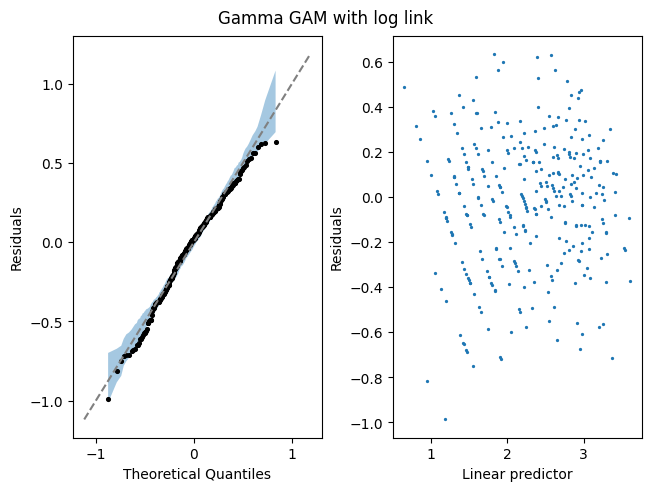

In [5]:

gam_gamma_log_link = GAM(
    {"o3": [S(var) for var in covariates]},
    family=Gamma(link="log"),
    )
gam_gamma_log_link.fit(data)
fig, axes = plt.subplots(ncols=2, layout="constrained")
gplt.qq(gam_gamma_log_link, ax=axes[0])
gplt.residuals_vs_linear_predictor(gam_gamma_log_link, ax=axes[1])
fig.suptitle("Gamma GAM with log link")
fig.show()


The residuals look much better! Let's test against the identity link

In [6]:
gam_gamma_id_link = GAM(
    {"o3": [S(var) for var in covariates]},
    family=Gamma(link="identity"),
    )
gam_gamma_id_link.fit(data)

models = {
    "gamma log link": gam_gamma_log_link,
    "gamma identity link": gam_gamma_id_link,
}

for name, model in models.items():
    print(f"{name}: AIC = {model.aic():.2f}, total EDF = {sum(model.edf()):.2f}")


gamma log link: AIC = 1653.13, total EDF = 25.34
gamma identity link: AIC = 1677.95, total EDF = 31.45


The multiplicative model (log link) looks better. Let's consider if we can drop any terms.

In [7]:
print(gam_gamma_log_link.summary())


Family: Gamma 
Link function: log 

Formula:
o3 ~ s(vh) + s(wind) + s(humidity) + s(temp) + s(ibh) + s(dpg) + 
    s(ibt) + s(vis) + s(doy) + 1

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.25587    0.01606   140.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(vh)       1.000  1.000 13.779 0.000245 ***
s(wind)     1.000  1.000  9.885 0.001830 ** 
s(humidity) 2.483  3.126  2.051 0.097958 .  
s(temp)     3.279  4.124  3.785 0.004761 ** 
s(ibh)      2.846  3.482  4.717 0.002354 ** 
s(dpg)      4.292  5.375 12.376  < 2e-16 ***
s(ibt)      1.002  1.004  1.851 0.174647    
s(vis)      3.000  3.753 10.350  5.3e-07 ***
s(doy)      5.433  6.624 24.170  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.785   Deviance explained =   83%
-REML = 848.41  Scale est. = 0.085066  n = 330

`ibt` has the highest p-value, followed by `humidity`. Let's consider dropping these

In [8]:
models = {
    "no_ibt": GAM(
        {"o3": [S(var) for var in covariates if var != "ibt"]},
        family=Gamma(link="log"),
    ),
    "no_ibt_or_humidity": GAM(
        {"o3": [S(var) for var in covariates if var not in ("ibt", "humidity")]},
        family=Gamma(link="log"),
    ),
}
for name, model in models.items():
    model.fit(data)
    print(f"{name}: AIC = {model.aic():.2f}, total EDF = {sum(model.edf()):.2f}")


no_ibt: AIC = 1652.65, total EDF = 24.32


no_ibt_or_humidity: AIC = 1653.64, total EDF = 22.19


- Both models are reasonable, but dropping only `ibt` gave the model with the lowest AIC. 
- We may favour the model without `humidity` if we want a simpler model!